#  UNCOVERING INCOME TAX FRAUD: A LOGISTIC REGRESSION APPROACH FOR DETECTION AND PREVENTION

Data Pre-processing

In [1]:
# Loading the OpenML Income Dataset
import pandas as pd
income_data = pd.read_csv("Census-Income-Dataset.csv")

In [2]:
# Displaying first 5 rows
income_data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,declared-income,actual-income
0,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K,>50K
1,53,?,135105,Bachelors,13,Divorced,?,Not-in-family,White,Female,0,0,50,United-States,<=50K,>50K
2,19,?,62534,Bachelors,13,Never-married,?,Own-child,Black,Female,0,0,40,Jamaica,<=50K,<=50K
3,32,Private,186824,HS-grad,9,Never-married,Machine-op-inspct,Unmarried,White,Male,0,0,40,United-States,<=50K,>50K
4,30,?,203834,Bachelors,13,Never-married,?,Not-in-family,Asian-Pac-Islander,Female,0,0,50,Taiwan,<=50K,>50K


In [3]:
# Structure of the dataset
income_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   education-num    48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   sex              48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   48842 non-null  object
 14  declared-income  48842 non-null  object
 15  actual-income    48842 non-null  object
dtypes: int64(6), object(10)
memory usage: 6.0+ MB


In [4]:
# No of rows and columns
income_data.shape

(48842, 16)

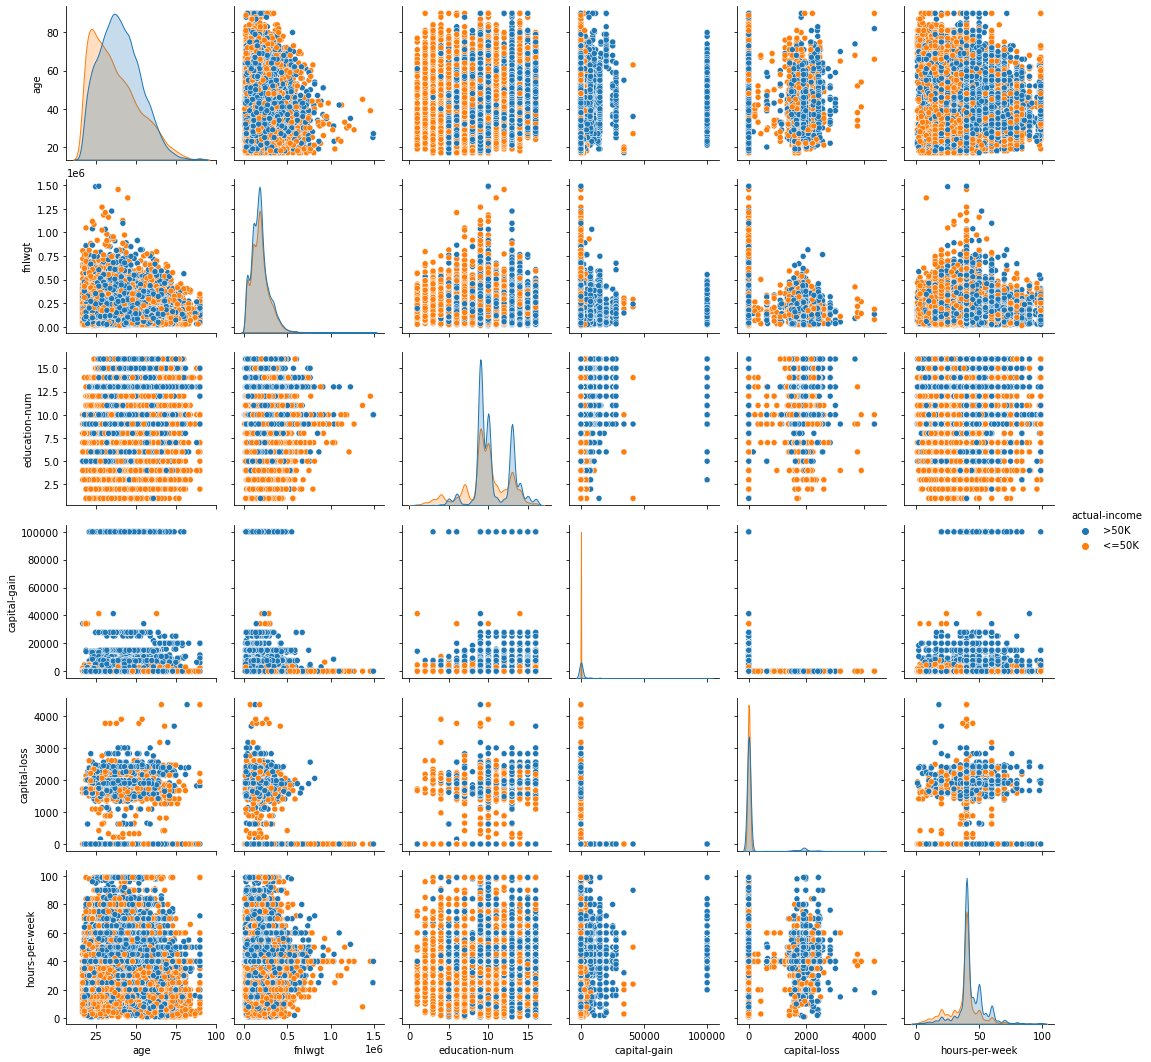

In [5]:
# Performing exploratory data analysis (EDA)
import matplotlib.pyplot as plt
import seaborn as sns
sns.pairplot(income_data[['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'declared-income', 'actual-income']], hue='actual-income')
plt.show()

In [6]:
# Feature engineering
relevant_features = ['age', 'workclass', 'education', 'marital-status', 'occupation', 'race', 'sex', 'hours-per-week', 'native-country', 'declared-income', 'actual-income']
income_data = income_data[relevant_features]

Data Splitting

In [7]:
# Flagging suspicious cases
income_data['suspicious'] = (income_data['actual-income'] == '>50K') & (income_data['declared-income'] == '<=50K')


In [8]:
# Splitting the dataset into 80% as training and 20% as testing.
from sklearn.model_selection import train_test_split
X = income_data.drop(['actual-income', 'suspicious'], axis=1)
y = income_data['actual-income']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Encode categorical variables and Scale the numerical variables

In [9]:
# Scaling the dataset to ensure that each feature has the same scale
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
# defining column transformer to encode categorical variables
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
# defining the columns that are categorical variables
categorical_cols = [col for col in X_train.columns if X_train[col].dtype == 'object']
# defining the column transformer with both the scaler and the encoder
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), [col for col in X_train.columns if col not in categorical_cols]),
        ('cat', categorical_transformer, categorical_cols)
    ])

# fit and transform the training and testing data
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

Training models

In [10]:
#Train various machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import warnings
warnings.filterwarnings('ignore')

models = [("Logistic Regression", LogisticRegression(random_state=42, max_iter=1000, solver='saga')),
("Decision Tree", DecisionTreeClassifier(random_state=42)),
("Random Forest", RandomForestClassifier(random_state=42)),
("Feed Forward Neural Network", MLPClassifier(random_state=42, max_iter=1000)),
("k-Nearest Neighbors", KNeighborsClassifier()),
("Naive Bayes", GaussianNB())]

#converting X_train and X_test from a sparse matrix to a dense matrix using numpy array before passing it to the models.
X_train = X_train.toarray()
X_test = X_test.toarray()

for name, model in models:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model.fit(X_train, y_train)

Model Evaluation

In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, precision_recall_curve, auc
import numpy as np
results = {}
for name, model in models:
    y_pred = model.predict(X_test)
    pos_label = '>50K'
    if pos_label not in np.unique(y_pred):
        pos_label = np.unique(y_pred)[0]
    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, pos_label=pos_label),
        'Recall': recall_score(y_test, y_pred, pos_label=pos_label),
        'F1-score': f1_score(y_test, y_pred, pos_label=pos_label)
    }
results_df = pd.DataFrame(results).T
print(results_df)

                             Accuracy  Precision    Recall  F1-score
Logistic Regression          0.997031   1.000000  0.994451  0.997218
Decision Tree                0.994268   0.994075  0.995216  0.994645
Random Forest                0.996724   0.999039  0.994834  0.996932
Feed Forward Neural Network  0.996520   0.998464  0.995025  0.996741
k-Nearest Neighbors          0.976354   0.972206  0.983927  0.978031
Naive Bayes                  0.909510   0.883704  0.956755  0.918780


Visualisation

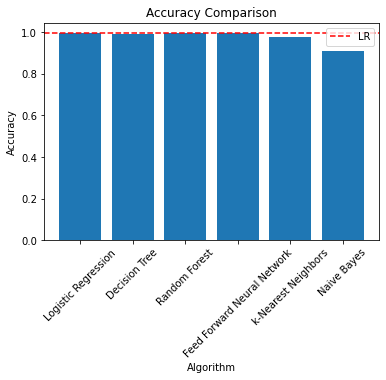

In [12]:
#visualisations comparation of the performance of different algorithms
# Bar Plot
import matplotlib.pyplot as plt

plt.bar(results_df.index, results_df['Accuracy'])
plt.xlabel('Algorithm')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.xticks(rotation=45)
plt.axhline(y=results_df.loc['Logistic Regression', 'Accuracy'], color='r', linestyle='--', label='LR')
plt.legend()
plt.show()

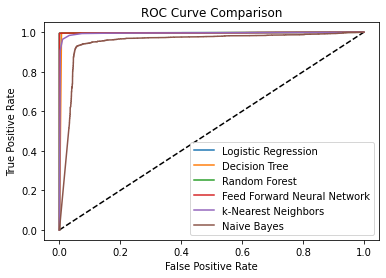

In [13]:
#ROC curve
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve

# convert categorical labels to binary labels
le = LabelEncoder()
y_test_binary = le.fit_transform(y_test)

plt.plot([0, 1], [0, 1], 'k--')
for name, model in models:
    fpr, tpr, thresholds = roc_curve(y_test_binary, model.predict_proba(X_test)[:, 1])
    plt.plot(fpr, tpr, label=name)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

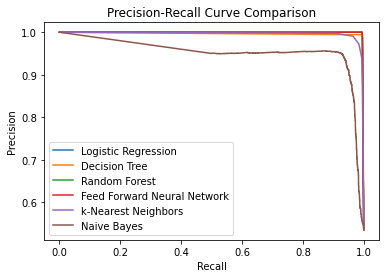

In [14]:
#Precision-Recall Curve
for name, model in models:
  precision, recall, thresholds = precision_recall_curve(y_test_binary, model.predict_proba(X_test)[:,1])
  plt.plot(recall, precision, label=name)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison')
plt.legend()
plt.show()

In [15]:
#Performing cross-validation 
from sklearn.model_selection import cross_val_score 
import numpy as np 
for name, model in models: 
    cv_scores = cross_val_score(model, X_train, y_train, cv=10) 
    print("Model: ", name) 
    print(f"Mean cross-validation score: {np.mean(cv_scores)}") 

Model:  Logistic Regression
Mean cross-validation score: 0.9974918911781835
Model:  Decision Tree
Mean cross-validation score: 0.9953933037282635
Model:  Random Forest
Mean cross-validation score: 0.9968264451464828
Model:  Feed Forward Neural Network
Mean cross-validation score: 0.9973383206637221
Model:  k-Nearest Neighbors
Mean cross-validation score: 0.9754047665018224
Model:  Naive Bayes
Mean cross-validation score: 0.9114735080383503


Hyperparameter Tuning

In [16]:
#Using hyperparameter tuning to optimize the performance of the best-performing model 
from sklearn.model_selection import GridSearchCV 
lr_params = {"C": np.logspace(-3, 3, 7)} 
lr_grid_search = GridSearchCV(LogisticRegression(random_state=42, max_iter=1000, solver='saga'), lr_params, cv=10) 
lr_grid_search.fit(X_train, y_train) 
best_lr_model = lr_grid_search.best_estimator_ 

In [18]:
#Evaluate the performance of the best-performing model
y_pred = best_lr_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
pos_label = '>50K'
precision = precision_score(y_test, y_pred, pos_label=pos_label)
recall = recall_score(y_test, y_pred, pos_label=pos_label)
f1 = f1_score(y_test, y_pred, pos_label=pos_label)
print(f"Best model performance: {best_lr_model}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("")

Best model performance: LogisticRegression(max_iter=1000, random_state=42, solver='saga')
Accuracy: 0.9970314259391954
Precision: 1.0
Recall: 0.9944508228090317
F1 Score: 0.9972176916434808



Model deployment

In [19]:
#importing libraries
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os

In [20]:
# Define the input data as a numpy array
input_data = np.array([[0.123, -0.456, -1.234, 0.789, -2.345, 3.123, -1.456, 1.234, -0.789, 2.345, -0.456]])

# Define the declared income and actual income variables
Declaredincome = '<=50K'
Actualincome = '>50K'

# Check the declared income and append appropriate values to input_data
if Declaredincome == '<=50K':
    input_data = np.hstack((input_data, [[1, 0]]))
else:
    input_data = np.hstack((input_data, [[0, 1]]))
if Actualincome == '<=50K':
    input_data = np.hstack((input_data, [[1, 0]]))
else:
    input_data = np.hstack((input_data, [[0, 1]]))

#Convert input data to FLOAT32
input_data = input_data.astype(np.float32)

#Reshape input data to the correct shape
input_shape = (1, 11)
input_data = np.reshape(input_data[:, :11], input_shape)

# Define TensorFlow model
input_shape = (11,)
model_input = keras.layers.Input(shape=input_shape, name="input")
model_output = keras.layers.Dense(1, activation="sigmoid", name="output")(model_input)
tf_model = keras.Model(inputs=model_input, outputs=model_output)

#Set the weights of the TensorFlow model
tf_model.layers[1].set_weights([best_lr_model.coef_[:, :11].T, best_lr_model.intercept_])

#Convert TensorFlow model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(tf_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

#Save the TFLite model to a file on desktop
file_path = os.path.join(os.path.expanduser('~'), 'Desktop', 'best_lr_model.tflite')
tf.io.write_file(file_path, tflite_model)

#Save the TFLite model to a file
file_path = "best_lr_model.tflite"
with open(file_path, "wb") as f:
    f.write(tflite_model)

#create an interpreter for the TensorFlow Lite model
interpreter = tf.lite.Interpreter(model_path=file_path)
interpreter.allocate_tensors()

#Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

#Set input data
interpreter.set_tensor(input_details[0]['index'], input_data)

#Run inference
interpreter.invoke()

#Get output and reshape to the correct shape
output_data = interpreter.get_tensor(output_details[0]['index'])
output_data = np.reshape(output_data, (1, 1))

#Testing the tensor flow model
if output_data[0][0] > 0.5:
    result = '1'
else:
    result = '0'
print(result)


INFO:tensorflow:Assets written to: C:\Users\Lenovo\AppData\Local\Temp\tmp5so4n86z\assets
1
